In [70]:
import scipy.io
data = scipy.io.loadmat('Data_ankle.mat')
ankle_data= data['ankle_data']
print(ankle_data.shape)

(48000, 7)


In [71]:
import pandas as pd
# Define column names
column_names = [
    'time', 
    'vgrf',  # vertical ground reaction force
    'trunk_angle',
    'hip_angle', 
    'knee_angle', 
    'ankle_angle', 
    'joint_moment'
]
df = pd.DataFrame(ankle_data, columns=column_names )
df.head()

,time,vgrf,trunk_angle,hip_angle,knee_angle,ankle_angle,joint_moment
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


In [72]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
data_to_scale = df.drop(columns=['time'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_scale)

In [73]:
normalized_df = pd.DataFrame(scaled_data, columns=column_names[1:])
normalized_df['time'] = df['time']
print(normalized_df)

           vgrf  trunk_angle  hip_angle  knee_angle  ankle_angle  \
0     -1.164248    -1.011654   1.165376    1.118800     0.427622   
1     -1.156822    -1.056365   1.166540    1.110820     0.423625   
2     -1.151147    -1.062878   1.171241    1.075539     0.405926   
3     -1.147700    -1.080574   1.180092    0.997836     0.366702   
4     -1.146576    -1.043329   1.190897    0.874748     0.304399   
...         ...          ...        ...         ...          ...   
47995  0.617661     0.710714  -0.270122   -0.654455    -0.768000   
47996  0.624962     0.846439  -0.343023   -0.691150    -0.795467   
47997  0.642917     0.955921  -0.410304   -0.725305    -0.818705   
47998  0.668348     1.085962  -0.468965   -0.754919    -0.837227   
47999  0.697389     1.115599  -0.516450   -0.778548    -0.850750   

       joint_moment    time  
0         -0.895137    0.00  
1         -0.939631    0.01  
2         -0.997326    0.02  
3         -1.008252    0.03  
4         -0.990733    0.04  
...

In [74]:
# split the dataset 

train_size = int(0.8 * len(normalized_df))
train_data = normalized_df[:train_size]
test_data = normalized_df[train_size:]
target_Ytest = test_data['joint_moment']

In [75]:
def extract_data_for_combination(columns):
    X_train = train_data[columns].values
    y_train = train_data['joint_moment'].values
    X_test = test_data[columns].values
    y_test = test_data['joint_moment'].values
    # Reshape for RNN
    X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    return X_train_rnn, y_train, X_test_rnn, y_test

In [76]:
from keras.models import Sequential
from keras.layers import  Dense, Dropout , LSTM ,  BatchNormalization

def create_rnn_model(input_shape):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    
    # Batch Normalization
    model.add(BatchNormalization())
    
    # Dense layer
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [77]:
from sklearn.metrics import mean_squared_error
import os 

# Function to train and evaluate models
def train_and_evaluate_rnn_model(input_comb,model_path):
    X_train_rnn, y_train, X_test_rnn, y_test = extract_data_for_combination(input_comb)
    rnn_model = create_rnn_model(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))
    history = rnn_model.fit(X_train_rnn, y_train, epochs=53, batch_size=64, validation_split=0.2, verbose=1)
    test_features_reshaped = X_test_rnn
    predictions = rnn_model.predict(test_features_reshaped).flatten()
    mse = mean_squared_error(y_test, predictions)
    rnn_model.save(model_path)
    return  mse, predictions, history



In [78]:
model_dir = 'models/'  # Directory to save the models
os.makedirs(model_dir, exist_ok=True)

# Define input combinations
input_combinations = {
    
    'all_angles_and_vgrf': ['vgrf','trunk_angle', 'hip_angle', 'knee_angle' ,'ankle_angle' ],
    'ankle_angle_only':['vgrf','ankle_angle',],
    'all_angles': ['trunk_angle', 'hip_angle', 'knee_angle' ,'ankle_angle'],
}
results = {}
for key, columns in input_combinations.items():
 
    model_path = os.path.join(model_dir, f"rnn_model_{key}.h5")
    rnn_mse, rnn_predictions, rnn_history = train_and_evaluate_rnn_model(
        columns , model_path
    )
    results[key] = {
        'rnn_mse': rnn_mse,
        'rnn_predictions': rnn_predictions,
        'rnn_history': rnn_history
    }
    
    print(f"Input Combination: {key}")
    print(f"RNN - MSE: {rnn_mse}")

Epoch 1/53
480/480 [==============================] - 2s 2ms/step - loss: 0.0864 - val_loss: 0.4443
Epoch 2/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0504 - val_loss: 0.0128
Epoch 3/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0455 - val_loss: 0.0114
Epoch 4/53
480/480 [==============================] - 1s 2ms/step - loss: 0.0442 - val_loss: 0.0100
Epoch 5/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0447 - val_loss: 0.0092
Epoch 6/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0434 - val_loss: 0.0089
Epoch 7/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0393 - val_loss: 0.0080
Epoch 8/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0390 - val_loss: 0.0086
Epoch 9/53
480/480 [==============================] - 1s 2ms/step - loss: 0.0399 - val_loss: 0.0075
Epoch 10/53
480/480 [==============================] - 1s 1ms/step - loss: 0.0401 - val_loss: 0.0095

In [79]:
mse_values = {key: {'rnn_mse': result['rnn_mse']} for key, result in results.items()}
print(mse_values)

{'all_angles_and_vgrf': {'rnn_mse': 0.007600975428288705}, 'ankle_angle_only': {'rnn_mse': 0.0768895372060808}, 'all_angles': {'rnn_mse': 0.0162583412639636}}


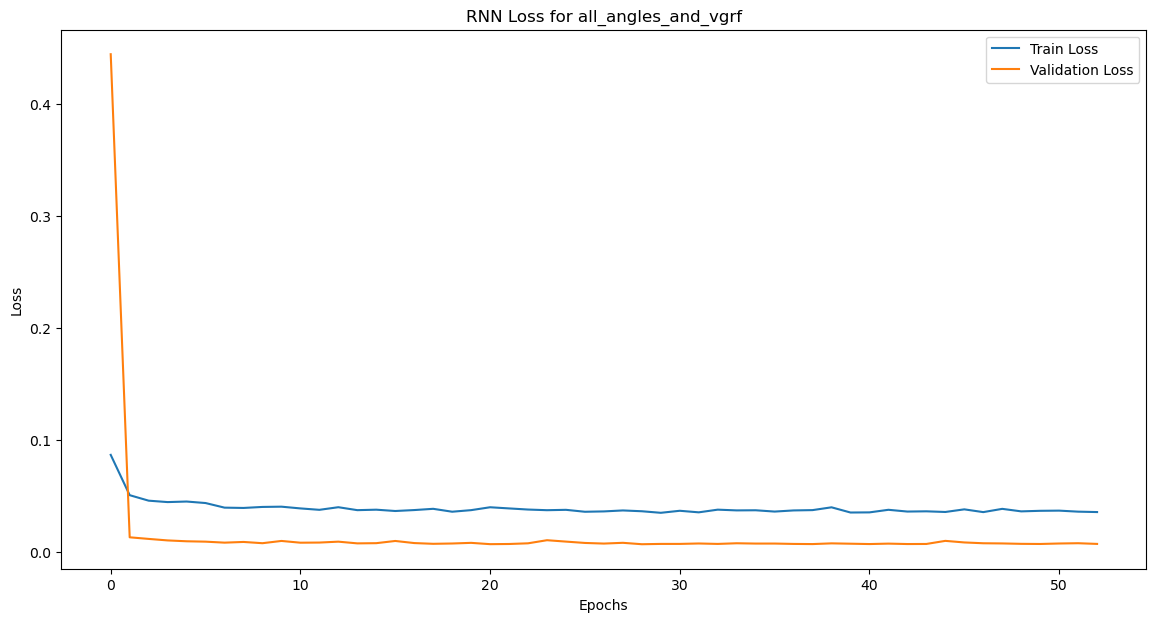

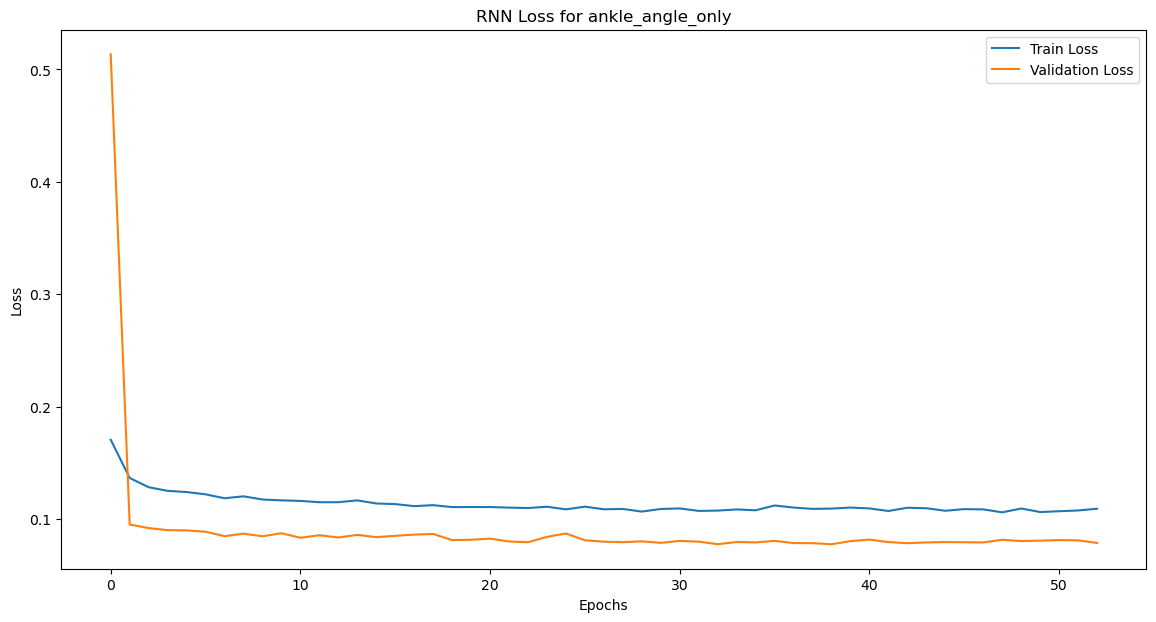

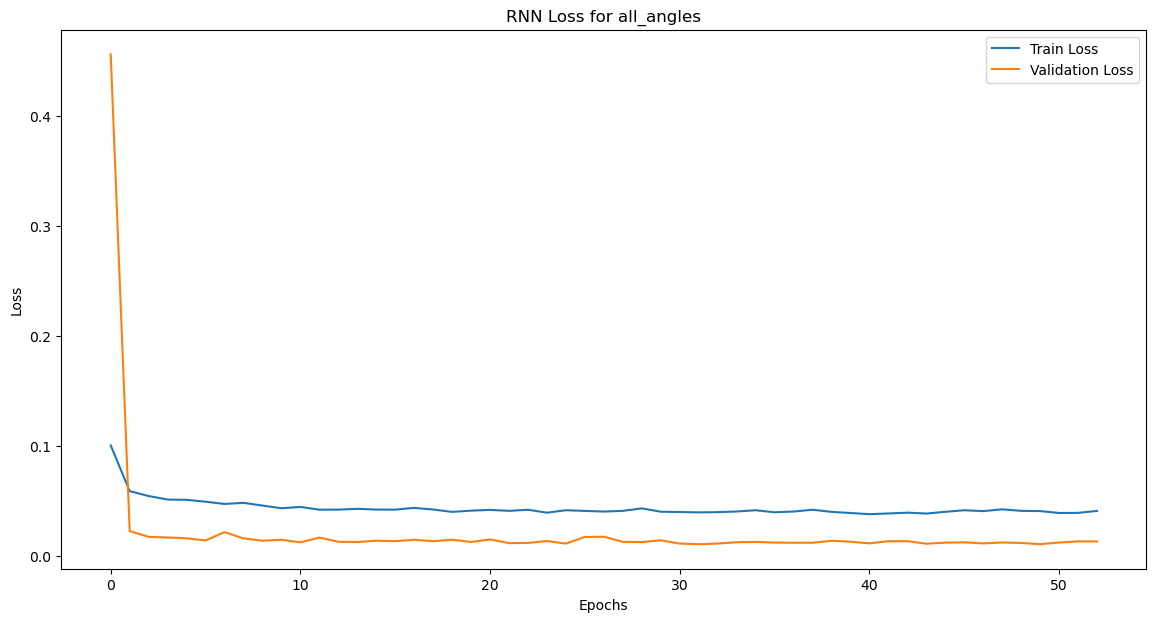

In [80]:
# Visualization of training and validation loss
import matplotlib.pyplot as plt

for key, result in results.items():
    
    # RNN loss
    plt.figure(figsize=(14, 7))
    plt.plot(result['rnn_history'].history['loss'], label='Train Loss')
    plt.plot(result['rnn_history'].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'RNN Loss for {key}')
    plt.legend()
    plt.show()

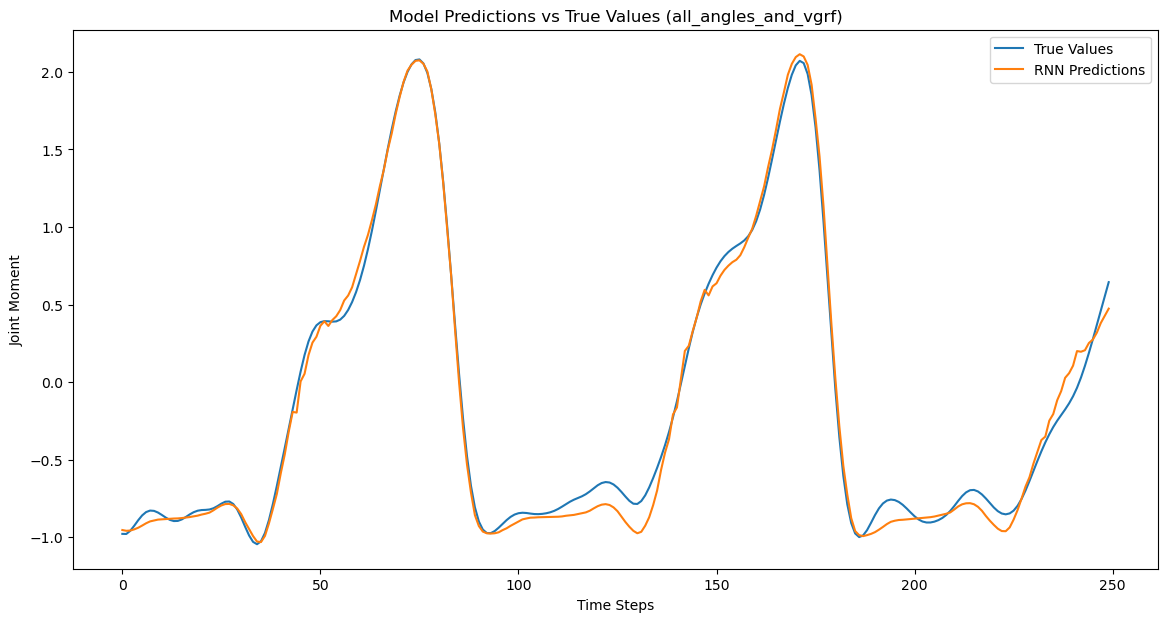

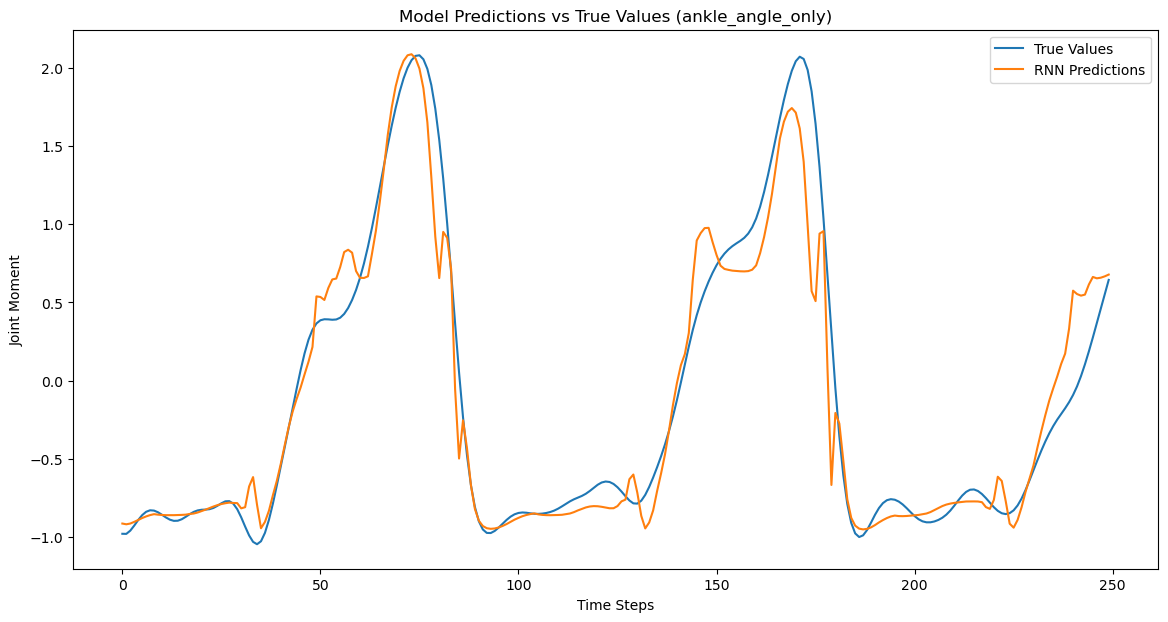

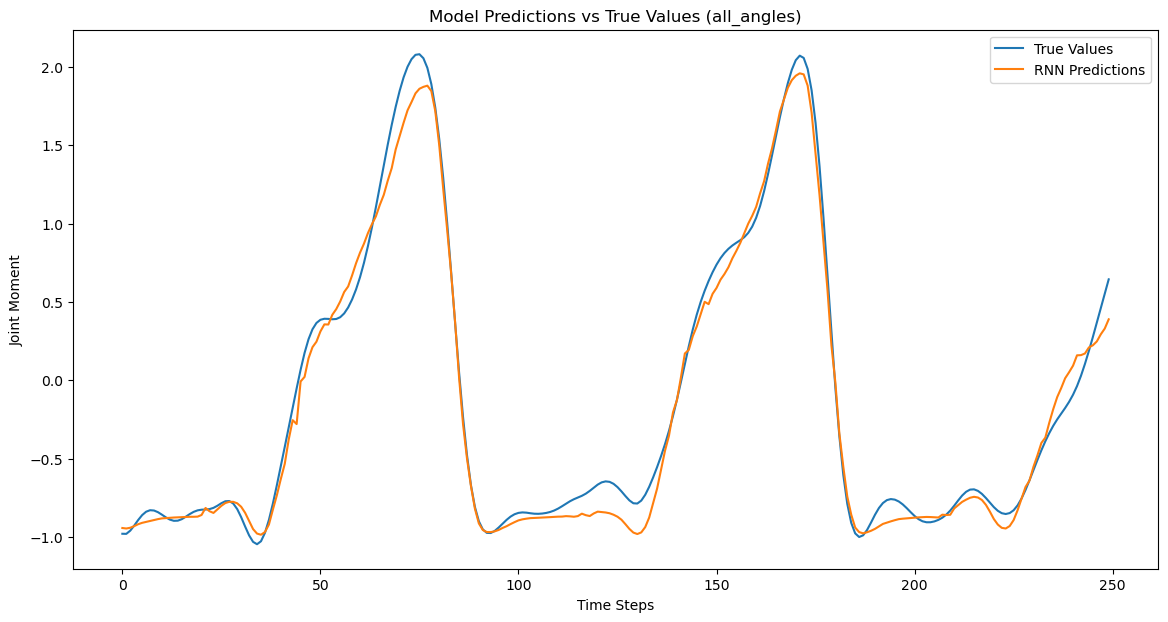

In [81]:
import matplotlib.pyplot as plt

# Number of data points to display
num_points_to_display = 250  # Adjust this number based on your preference

for key, result in results.items():
    plt.figure(figsize=(14, 7))
    
    # Select a subset of the data
    Y_testing_subset = target_Ytest.values[:num_points_to_display]
    rnn_predictions_subset = result['rnn_predictions'][:num_points_to_display]
    
    # Plot the subset of the data
    plt.plot(Y_testing_subset, label='True Values')
    plt.plot(rnn_predictions_subset, label='RNN Predictions')
    
    plt.xlabel('Time Steps')
    plt.ylabel('Joint Moment')
    plt.title(f'Model Predictions vs True Values ({key})')
    plt.legend()
    plt.show()